<h1>1. Import</h1>

In [1]:
#import des librairies
%pylab inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from textblob import Word
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.stem.snowball import SnowballStemmer
from spellchecker import SpellChecker
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from xgboost import plot_importance, to_graphviz
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import feature_extraction, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from gensim.utils import tokenize
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize


Populating the interactive namespace from numpy and matplotlib


In [2]:
#ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#chargement des données
#remplacement de None par NaN
#décimal avec un point plutôt qu'une virgule dans le dataframe afin que les variables soient de type float
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')

In [4]:
#affichage des 5 premières lignes du dataframe
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Caroline,Belgique,1.0,2018-07-30 00:00:00,Exceptionnel,"Établissement recent, propre, soigne, chouette...",Rien,10.0,Hôtel,Paris,8.5
1,Olivier51,France,0.0,2020-03-16 00:00:00,Fabuleux,"Accueil très chaleureux, chambre calme...tout ...",NaN,9.0,Hôtel,Paris,8.5
2,Marc,France,0.0,2020-03-11 00:00:00,Exceptionnel,Tout bié sauf le wifi catastrophiquement lent!...,NaN,9.6,Hôtel,Paris,8.5
3,Marie-claire,France,0.0,2020-03-08 00:00:00,Exceptionnel,NaN,Hôtel parfait. Quartier sympa.,10.0,Hôtel,Paris,8.5
4,Pierre,France,0.0,2020-03-06 00:00:00,Fabuleux,Excellent rapport qualité prix. Personnel très...,NaN,9.0,Hôtel,Paris,8.5


<h1>2. Exploration, nettoyage des données et construction du dataset pour le machine learning</h1>

In [5]:
#dimensions du dataframe
print('Le dataset a {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

Le dataset a 30946 lignes et 11 colonnes.


In [6]:
#affichage des variables
print('Les différents variables sont : {}.'.format(df.columns.tolist()))

Les différents variables sont : ['nom', 'pays', 'favorite', 'date', 'titre', 'bons_points', 'mauvais_points', 'note', 'type_etablissement', 'lieu', 'note_etablissement'].


In [7]:
#Existe-t-il des variables non renseignées?
df.isnull().values.any()

True

In [8]:
#affichage du nombre de valeurs manquantes selon chaque variable
df.isnull().sum()

nom                    395
pays                   452
favorite                15
date                   410
titre                  432
bons_points           2359
mauvais_points        8540
note                   410
type_etablissement      15
lieu                    15
note_etablissement      15
dtype: int64

In [9]:
#type de chaque variable
df.dtypes

nom                    object
pays                   object
favorite               object
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [10]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,30551,30494,30931,30536,30514,28587,22406,30536.000000,30931,30931,30931.000000
unique,5838,127,2,1246,9611,22578,18151,NaN,11,18,NaN
top,Anonyme,France,0.0,2020-02-16 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,650,25991,30211,205,4763,1502,833,NaN,25927,12888,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.977607,NaN,NaN,7.903485
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.396143,NaN,NaN,0.701262
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,5.300000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,NaN,NaN,7.300000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,8.400000


In [11]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
df.drop(['nom', 'pays', 'favorite', 'date', 'note', 'type_etablissement', 'lieu', 'note_etablissement'],1,inplace=True)
df.head()

,titre,bons_points,mauvais_points
0,Exceptionnel,"Établissement recent, propre, soigne, chouette...",Rien
1,Fabuleux,"Accueil très chaleureux, chambre calme...tout ...",NaN
2,Exceptionnel,Tout bié sauf le wifi catastrophiquement lent!...,NaN
3,Exceptionnel,NaN,Hôtel parfait. Quartier sympa.
4,Fabuleux,Excellent rapport qualité prix. Personnel très...,NaN


In [14]:
#remplacement des Nan par ''
df = df.fillna('')
#suppression de deux phrases récurrentes dans les données
df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [15]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['titre'])

In [16]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [17]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [18]:
#str.lower : mettre tous les éléments en minuscule
#str.cat : concaténation des strings avec le séparateur donné en paramètre
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres et retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûçæœ]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#suppression des caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [19]:
#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [20]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,bien,9543
1,agréable,3078
2,séjour,2600
3,exceptionnel,2237
4,fabuleux,1635
5,hôtel,1506
6,prix,1223


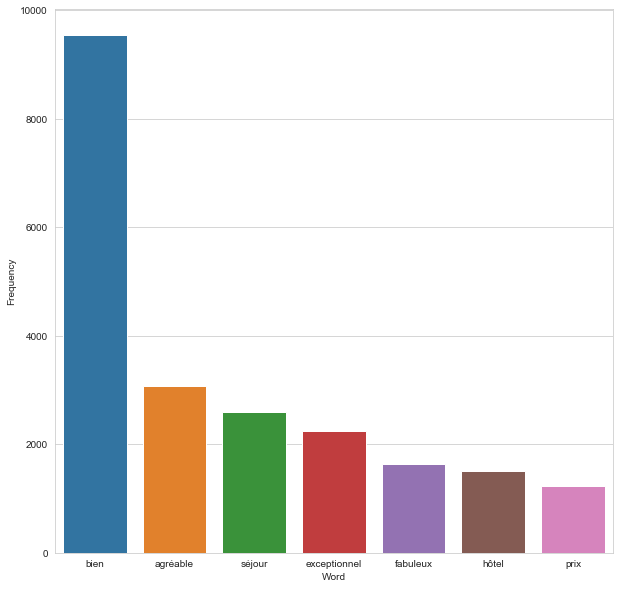

In [21]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

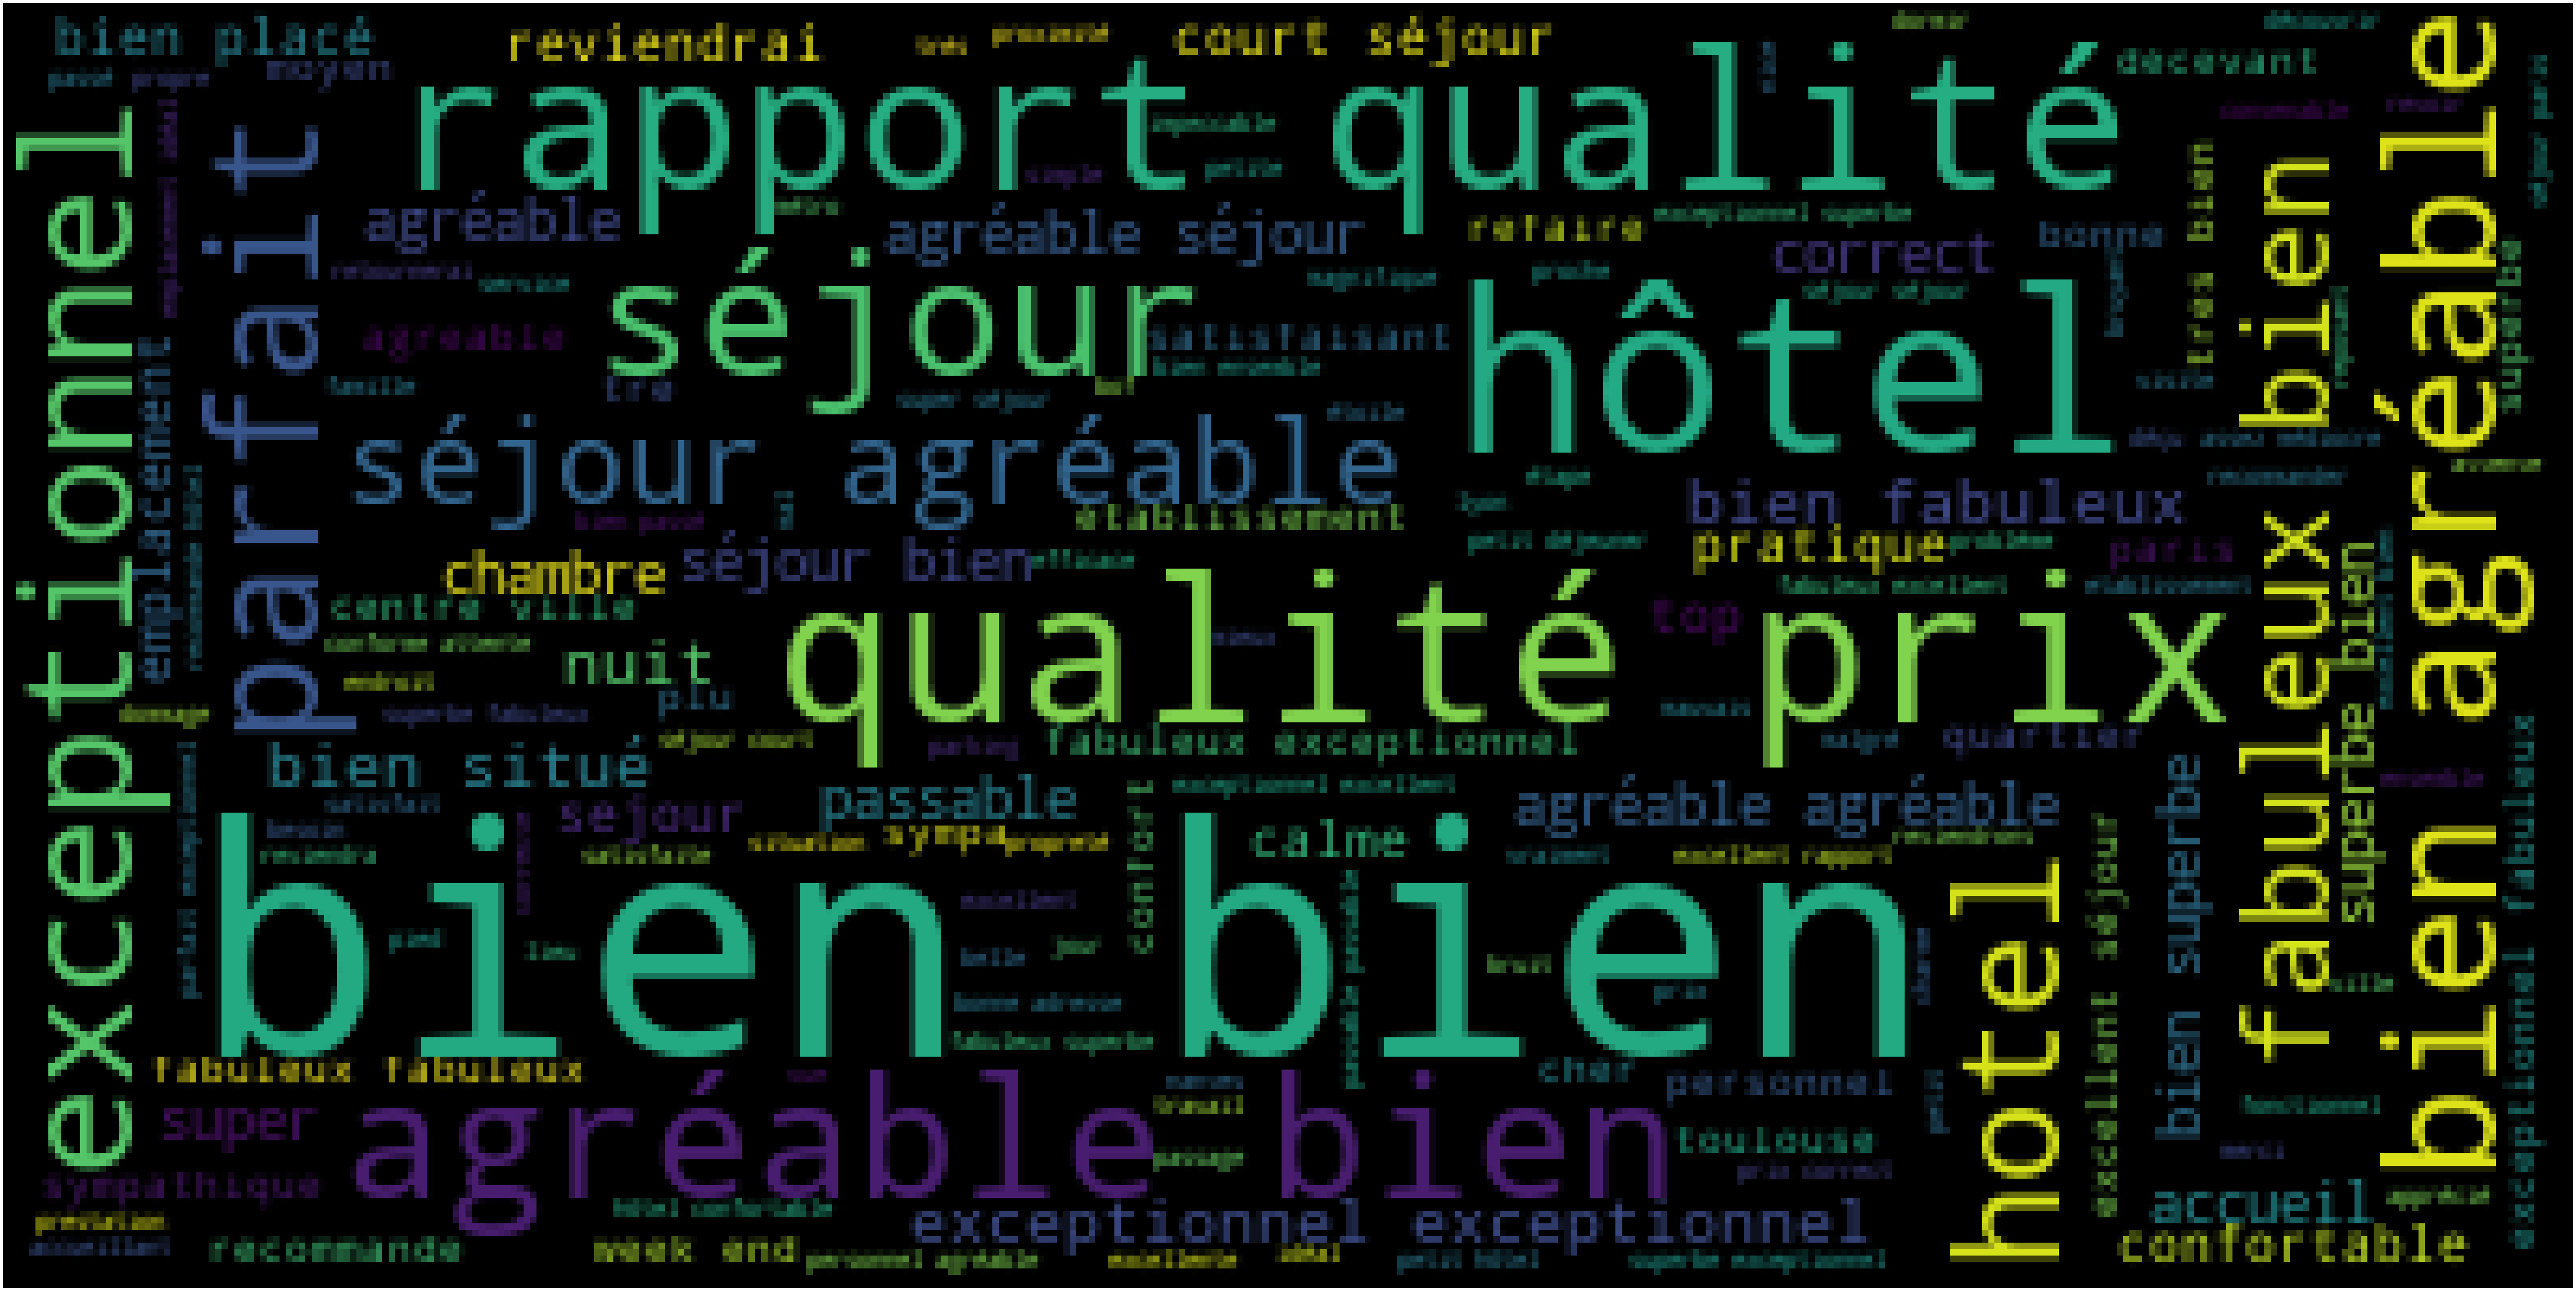

In [22]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [23]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['bons_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [24]:
#supprimer les caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [25]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,personnel,7096
1,petit,6657
2,chambre,6587
3,déjeuner,5299
4,bien,5126
5,accueil,4875
6,emplacement,4508


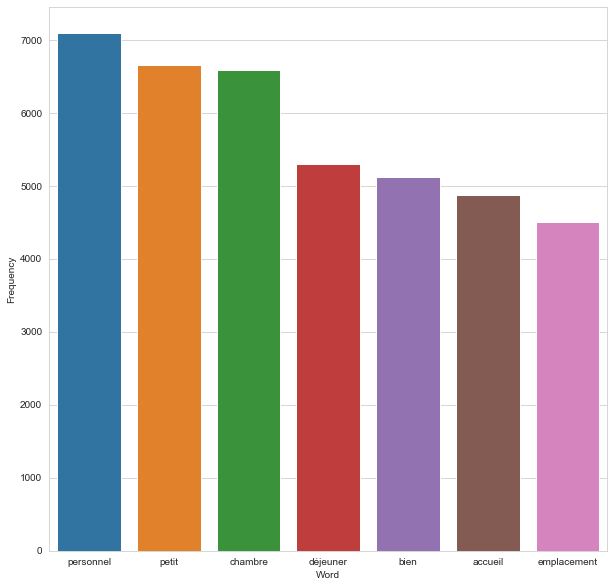

In [26]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

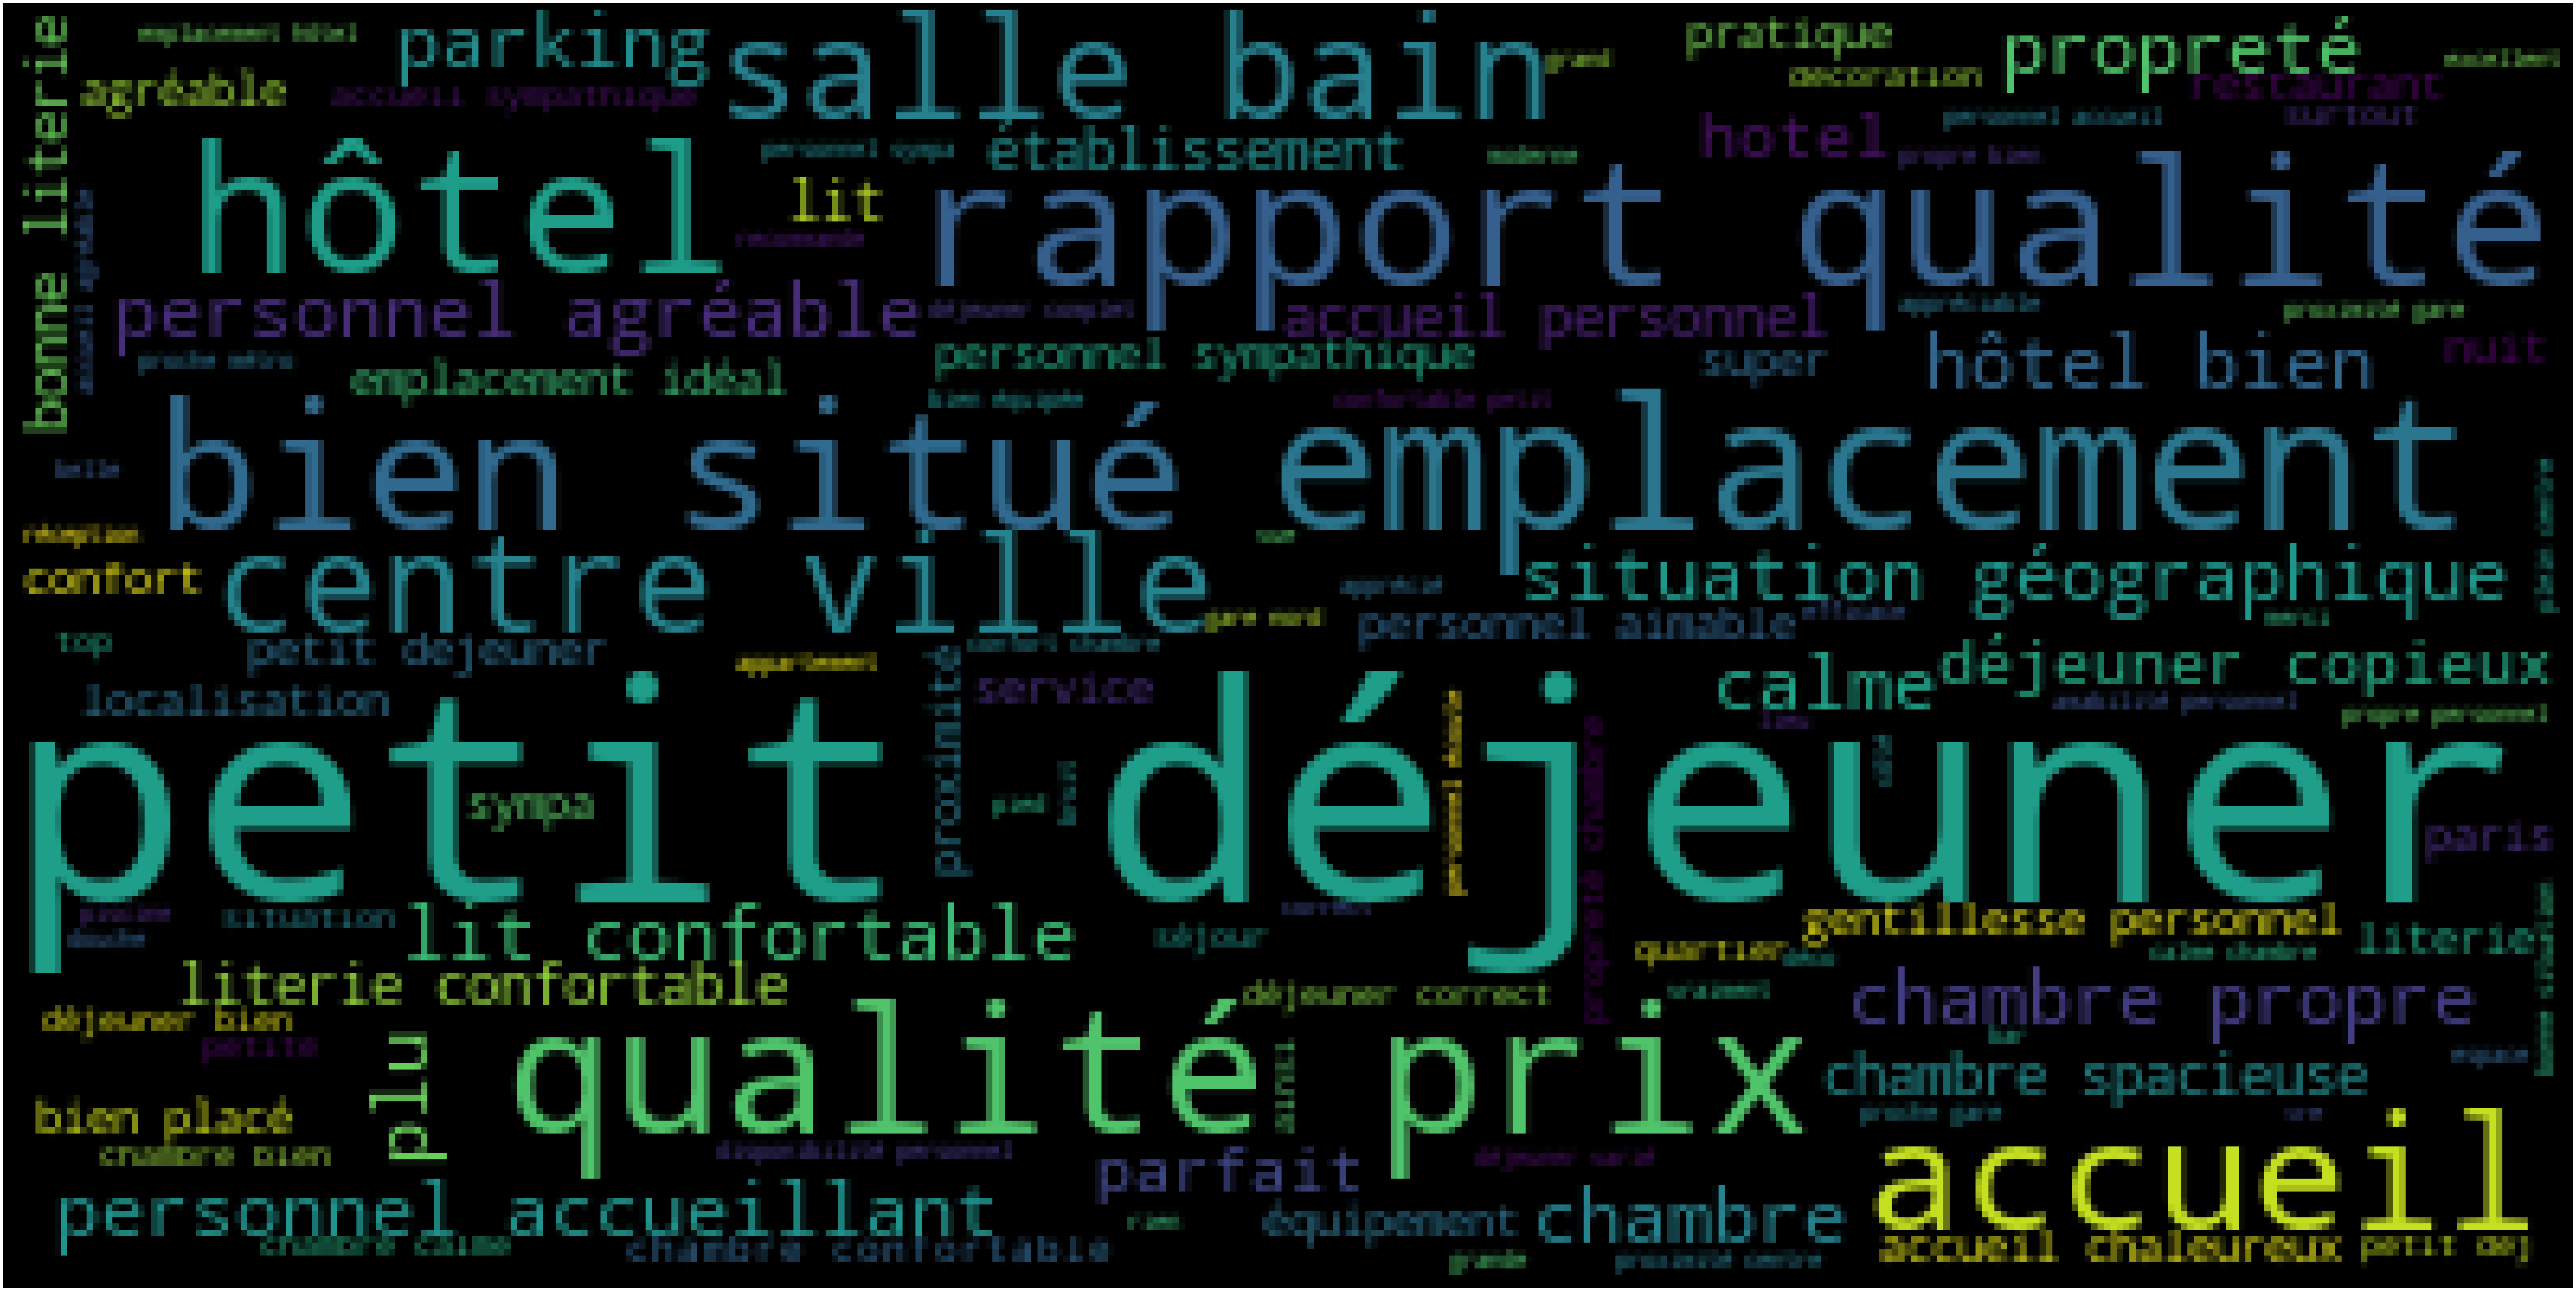

In [27]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [28]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['mauvais_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [29]:
#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [30]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,chambre,6337
1,petit,3380
2,salle,3138
3,déjeuner,2309
4,bain,2243
5,douche,2047
6,rien,1998


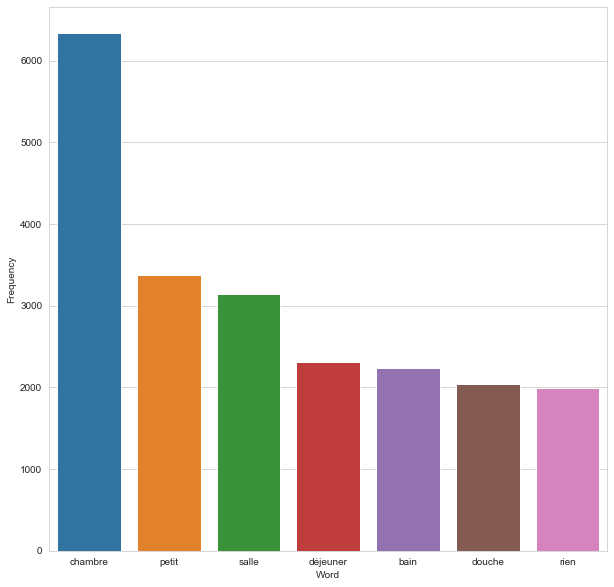

In [31]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

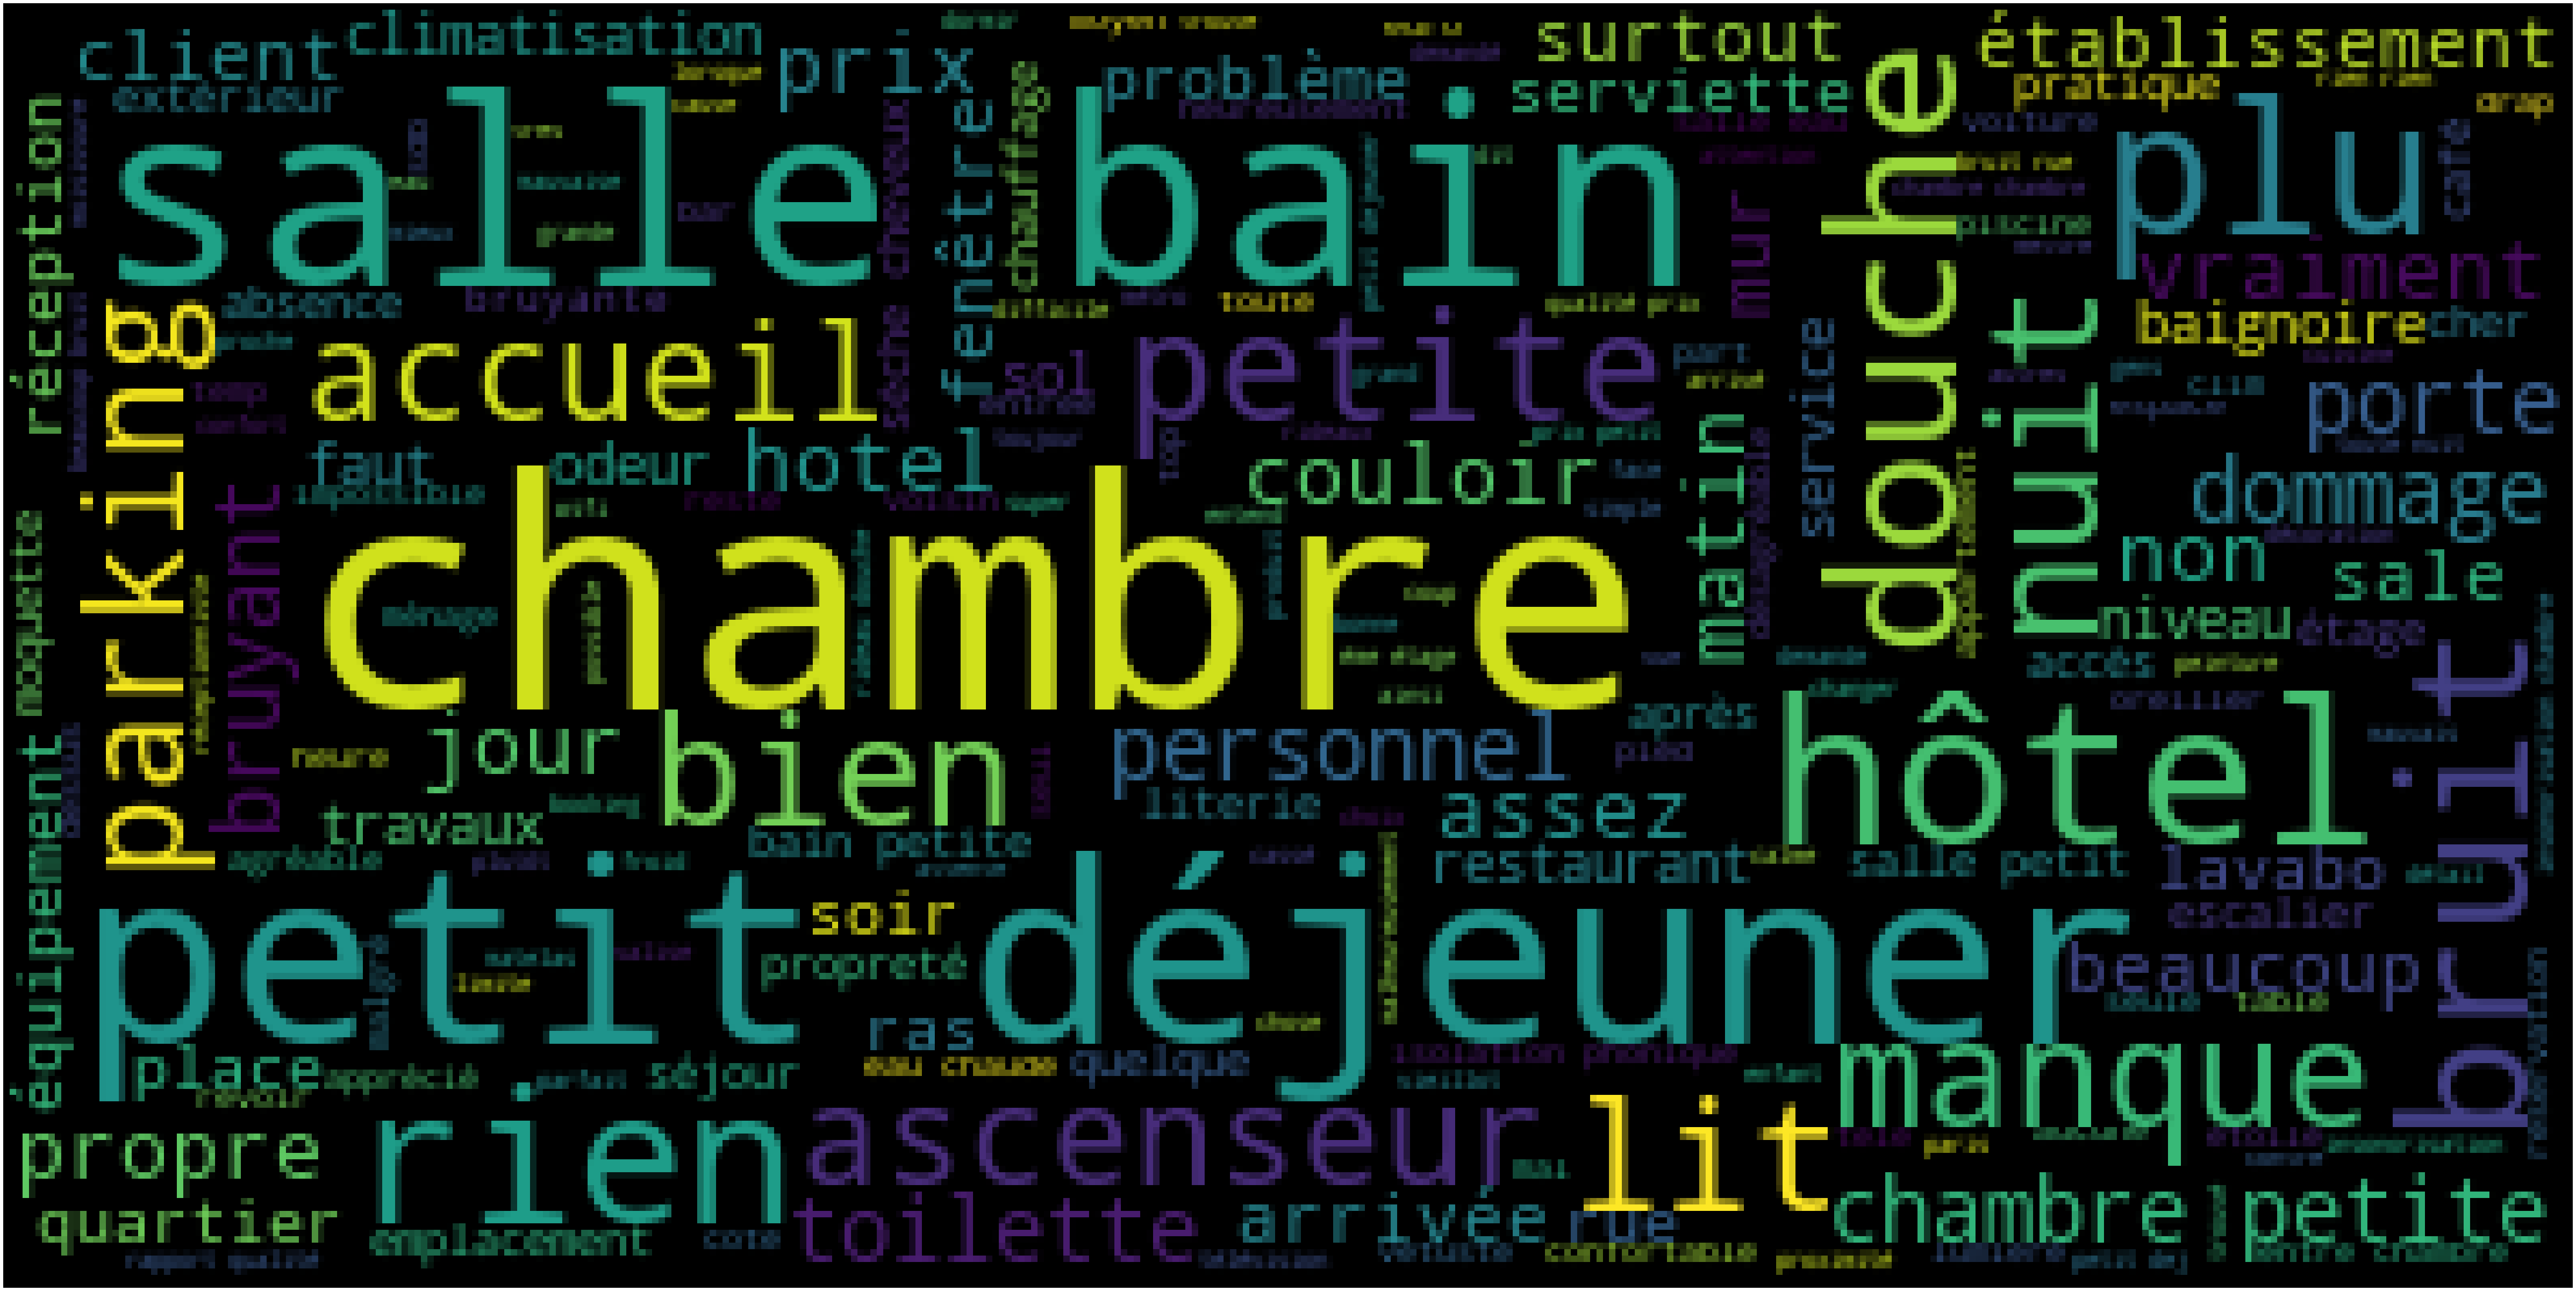

In [32]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [33]:
#concaténation des colonnes bons points et muavais points, axis=0
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['bons_points', 'mauvais_points'])

df23=df22['bons_points']
df24=df22['mauvais_points']

In [34]:
df23=pd.DataFrame(data=df23)
#df23['polarite']=1
df23.head()

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...


In [35]:
df24=pd.DataFrame(data=df24)
#df24['polarité']=0
df24.columns = ['bons_points']
df24.head()

,bons_points
0,Rien
1,
2,
3,Hôtel parfait. Quartier sympa.
4,


In [36]:
frames = [df23, df24]
result = pd.concat(frames)
result

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...
...,...
30941,C'est regrettable de ne pas avoir de plateau d...
30942,Rien tout étais au top! Merci!
30943,Rien
30944,


In [37]:
df21 = result['bons_points']
df21 = pd.DataFrame(df21, columns=['bons_points'])

In [38]:
df21.head()

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...


In [39]:
df21.columns=['sentences']

In [40]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

,sentences
0,"établissement recent, propre, soigne, chouette..."
1,"accueil très chaleureux, chambre calme...tout ..."
2,tout bié sauf le wifi catastrophiquement lent!...
3,
4,excellent rapport qualité prix. personnel très...


In [41]:
df21.shape

(58844, 1)

In [42]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ-]+',' ', str(x))) 
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [43]:
stop = stopwords.words('french')

In [44]:
#suppression des mots "vides" dans le dataframe
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [45]:
df22=df21.copy()

In [46]:
type(df22)

pandas.core.frame.DataFrame

In [47]:
df22.head()

,sentences
0,établissement recent propre soigne chouette de...
1,accueil très chaleureux chambre calme tout pas...
2,tout bié sauf wifi catastrophiquement lent meg...
3,
4,excellent rapport qualité prix personnel très ...


In [48]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [49]:
#df21['sentences'].str.contains(r'[0-9]').any()

In [50]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [52]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [53]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,0.261429
1,0.422500
2,-0.066667
3,0.000000
4,0.487500


In [54]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [55]:
df_polarity_desc1.head()

,sentiment,polarite
0,0.261429,positive
1,0.422500,positive
2,-0.066667,negative
3,0.000000,neutre
4,0.487500,positive


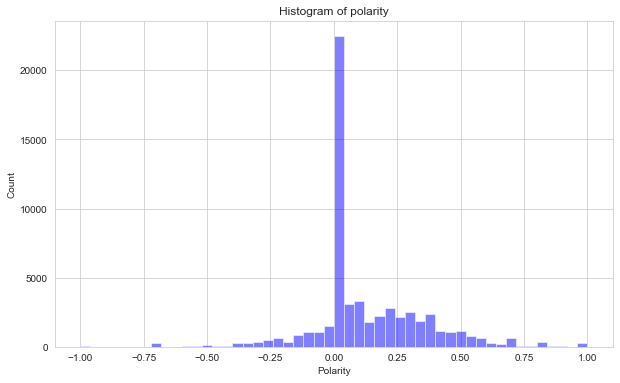

In [56]:
#histogramme de la polarité des commentaires
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_polarity_desc1.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

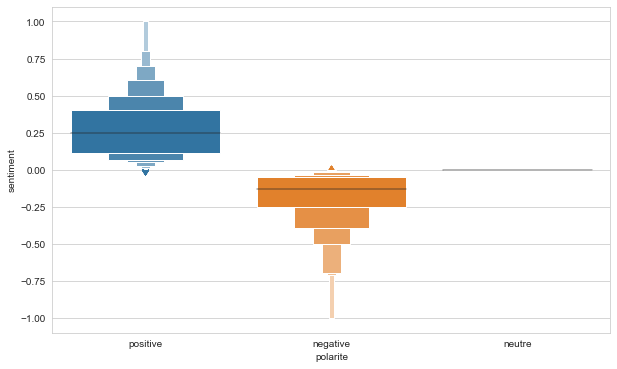

In [57]:
#boxenplot de la polarité des commenatires, boxplot avec plus de quartiles
plt.figure(figsize=(10,6))
sns.boxenplot(x='polarite', y='sentiment', data=df_polarity_desc1)
plt.show();

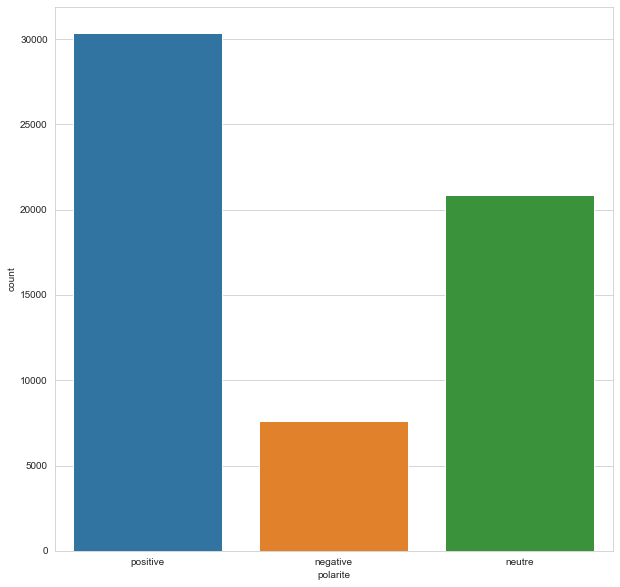

In [58]:
#countplot des modalités correspondant à la polarité des commentaires
df_polarity_desc1.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc1)

In [59]:
pourcentage_positive = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "positive")])) / len(df_polarity_desc1)
pourcentage_negative = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "negative")])) / len(df_polarity_desc1)

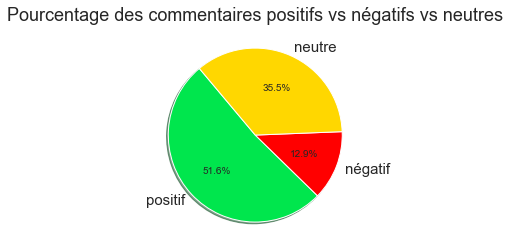

In [60]:
#diagramme circulaire des modalités de la polarité des commentaires
pourcentage_positive = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "positive")])) / len(df_polarity_desc1)
pourcentage_negative = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "negative")])) / len(df_polarity_desc1)
pourcentage_neutre = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "neutre")])) / len(df_polarity_desc1)

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs vs neutres", fontsize=18)
labels = ['positif', 'négatif', 'neutre']
sizes = [pourcentage_positive, pourcentage_negative, pourcentage_neutre]
#explode = (0, 0.2)  # seulement détacher le second groupe

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, startangle=130, colors = ['#00e64d', 'r', '#FFD700'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [61]:
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df23=df['note']
df24=df['note']
frames = [df23, df24]
df_notes = pd.concat(frames)
df_notes.shape

(61892,)

In [62]:
type(df_notes)

pandas.core.series.Series

In [63]:
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    negative
3      neutre
4    positive
Name: polarite, dtype: object

In [64]:
df_notes.reset_index(drop=True, inplace=True)
df_polarity_desc1_polarite.reset_index(drop=True, inplace=True)
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [65]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,negative,9.6
3,neutre,10.0
4,positive,9.0


In [66]:
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [67]:
type(df_corr)

pandas.core.frame.DataFrame

In [68]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,negative,9.6
4,positive,9.0
5,positive,7.9


In [69]:
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

,polarite,note
0,1,10.0
1,1,9.0
2,0,9.6
4,1,9.0
5,1,7.9


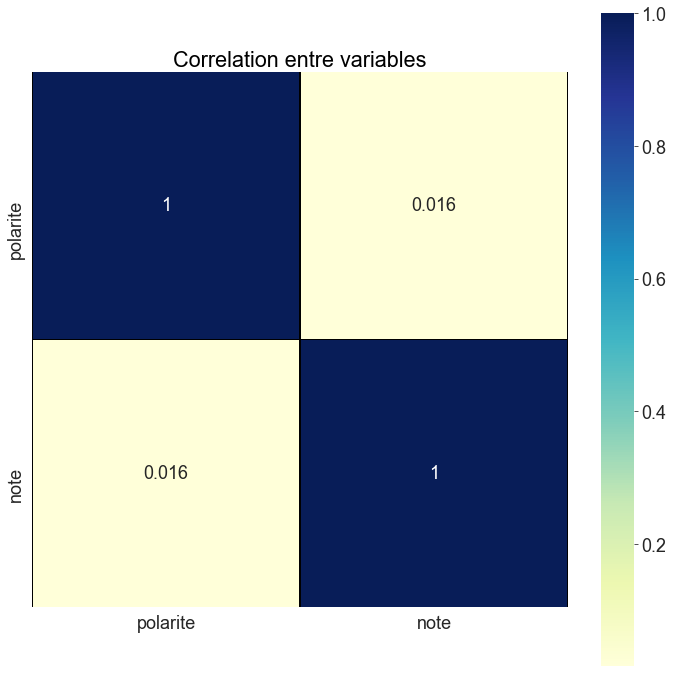

In [70]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [71]:
#concaténation des trois colonnes correspondant aux commentaires sur les hôtels
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['titre', 'bons_points', 'mauvais_points'])

df21 = df22['titre'].map(str) + ' ' + df22['bons_points'].map(str) + ' ' + df22['mauvais_points'].map(str)

df21

0        Exceptionnel Établissement recent, propre, soi...
1        Fabuleux  Accueil très chaleureux, chambre cal...
2        Exceptionnel Tout bié sauf le wifi catastrophi...
3          Exceptionnel nan Hôtel parfait. Quartier sympa.
4        Fabuleux  Excellent rapport qualité prix. Pers...
                               ...                        
30941    Exceptionnel L'hôtel est agréable et confortab...
30942    Exceptionnel La chambre, le personnel au top e...
30943    Hôtel très confortable La chambre, ses équipem...
30944         Déjà utilisé plusieurs fois Salle claire nan
30945           Bien  La situation face à la gare Le bruit
Length: 30946, dtype: object

In [72]:
#convertir series en dataframe
df21 = df21.to_frame(name="sentences")

In [73]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

,sentences
0,"exceptionnel établissement recent, propre, soi..."
1,"fabuleux accueil très chaleureux, chambre cal..."
2,exceptionnel tout bié sauf le wifi catastrophi...
3,exceptionnel nan hôtel parfait. quartier sympa.
4,fabuleux excellent rapport qualité prix. pers...


In [74]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ-]+',' ', str(x))) 
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [75]:
#suppression des mots "vides" dans le dataframe
stop = stopwords.words('french')
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [76]:
df22=df21.copy()

In [77]:
type(df22)

pandas.core.frame.DataFrame

In [78]:
df22.head()

,sentences
0,exceptionnel établissement recent propre soign...
1,fabuleux accueil très chaleureux chambre calme...
2,exceptionnel tout bié sauf wifi catastrophique...
3,exceptionnel nan hôtel parfait quartier sympa
4,fabuleux excellent rapport qualité prix person...


In [79]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [80]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [81]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [82]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,2.537500e-01
1,5.380000e-01
2,1.387779e-17
3,4.000000e-01
4,5.900000e-01


In [83]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [84]:
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df_notes = df.iloc[:,7]
#df_notes = pd.DataFrame(data=df_notes)
df_notes.head()

0    10.0
1     9.0
2     9.6
3    10.0
4     9.0
Name: note, dtype: float64

In [85]:
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: polarite, dtype: object

In [86]:
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [87]:
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [88]:
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

,polarite,note
0,1,10.0
1,1,9.0
2,1,9.6
3,1,10.0
4,1,9.0


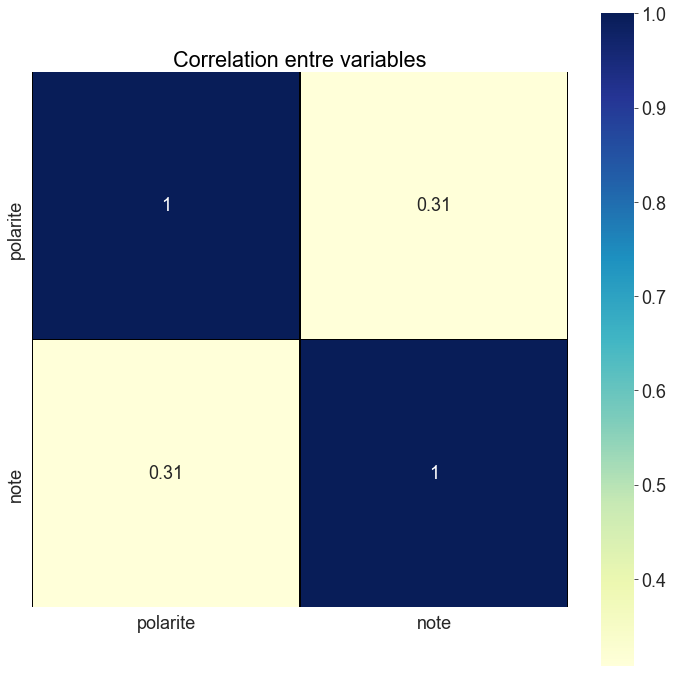

In [89]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [90]:
df_polarity_desc1.head()

,sentiment,polarite
0,2.537500e-01,positive
1,5.380000e-01,positive
2,1.387779e-17,positive
3,4.000000e-01,positive
4,5.900000e-01,positive


In [91]:
df_polarity_desc1.columns

Index(['sentiment', 'polarite'], dtype='object')

In [92]:
#Transformation des valeurs de la variable polarite en 1 et 0
#pas besoin d'utiliser le module scikit-learn car on peut le faire directement 
df_polarity_desc1['polarite'] = np.where(df_polarity_desc1['polarite'] == 'positive', 1, 0)
df_polarity_desc1 = df_polarity_desc1.reset_index(drop=True)
df_polarity_desc1.head()

,sentiment,polarite
0,2.537500e-01,1
1,5.380000e-01,1
2,1.387779e-17,1
3,4.000000e-01,1
4,5.900000e-01,1


In [93]:
df_polarity_desc1.drop(['sentiment'],1,inplace=True)
df_polarity_desc1.head()

,polarite
0,1
1,1
2,1
3,1
4,1


In [94]:
df21.head()

0    exceptionnel établissement recent propre soign...
1    fabuleux accueil très chaleureux chambre calme...
2    exceptionnel tout bié sauf wifi catastrophique...
3        exceptionnel nan hôtel parfait quartier sympa
4    fabuleux excellent rapport qualité prix person...
Name: sentences, dtype: object

In [95]:
df21.head()
comments = pd.DataFrame(data=df21)
comments.columns = ['sentences']
comments.head()
comments.shape
type(comments)

pandas.core.frame.DataFrame

In [96]:
df_polarity_desc1.shape
type(df_polarity_desc1)

pandas.core.frame.DataFrame

In [97]:
dataset = pd.concat([comments, df_polarity_desc1])

In [98]:
comments.reset_index(drop=True, inplace=True)
df_polarity_desc1.reset_index(drop=True, inplace=True)
#concaténation des deux datasets en un seul que l'on nommera df
df = pd.concat([df_polarity_desc1, comments], axis = 1)
#df.head(100)

In [99]:
df.columns=['sentiment', 'sentence']
df.head(100)

,sentiment,sentence
0,1,exceptionnel établissement recent propre soign...
1,1,fabuleux accueil très chaleureux chambre calme...
2,1,exceptionnel tout bié sauf wifi catastrophique...
3,1,exceptionnel nan hôtel parfait quartier sympa
4,1,fabuleux excellent rapport qualité prix person...
...,...,...
95,0,très bien petit dej pris a hotel parce vue pet...
96,1,confort quartir charme situation géographique ...
97,1,fabuleux situation géographique calme proximit...
98,1,exceptionnel emplacement appréciable séjour tr...


In [100]:
#token
def identify_tokens(row):
    review = row['sentence']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return tokens

df['sentence'] = df.apply(identify_tokens, axis=1)

In [101]:
df.head()

,sentiment,sentence
0,1,"[exceptionnel, établissement, recent, propre, ..."
1,1,"[fabuleux, accueil, très, chaleureux, chambre,..."
2,1,"[exceptionnel, tout, bié, sauf, wifi, catastro..."
3,1,"[exceptionnel, nan, hôtel, parfait, quartier, ..."
4,1,"[fabuleux, excellent, rapport, qualité, prix, ..."


In [102]:
#lemmatisation, en raison du temps pas de possibilité de rajouter getPos 
lemmatizer = FrenchLefffLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text
df['sentence'].apply(lambda x : word_lemmatizer(x))

0        [exceptionnel, établissement, recent, propre, ...
1        [fabuleux, accueil, très, chaleureux, chambre,...
2        [exceptionnel, tout, bié, sauf, wifi, catastro...
3        [exceptionnel, nan, hôtel, parfait, quartier, ...
4        [fabuleux, excellent, rapport, qualité, prix, ...
                               ...                        
30941    [exceptionnel, hôtel, agréable, confortable, t...
30942    [exceptionnel, chambre, personnel, top, surtou...
30943    [hôtel, très, confortable, chambre, équipement...
30944    [déjà, utilisé, plusieurs, foi, salle, claire,...
30945                 [bien, situation, face, gare, bruit]
Name: sentence, Length: 30946, dtype: object

In [103]:
#stemmatisation
stemmer = SnowballStemmer("french")
df['sentence'] = df['sentence'].apply(lambda x: [stemmer.stem(y) for y in x])
df.head()

,sentiment,sentence
0,1,"[exceptionnel, établ, recent, propr, soign, ch..."
1,1,"[fabul, accueil, tres, chaleur, chambr, calm, ..."
2,1,"[exceptionnel, tout, bi, sauf, wif, catastroph..."
3,1,"[exceptionnel, nan, hôtel, parf, quarti, symp]"
4,1,"[fabul, excellent, rapport, qualit, prix, pers..."


In [104]:
df['sentence'] = df['sentence'].apply(lambda x: ' '.join(x))

In [105]:
df.head()

,sentiment,sentence
0,1,exceptionnel établ recent propr soign chouet d...
1,1,fabul accueil tres chaleur chambr calm tout pa...
2,1,exceptionnel tout bi sauf wif catastroph lent ...
3,1,exceptionnel nan hôtel parf quarti symp
4,1,fabul excellent rapport qualit prix personnel ...


In [106]:
df=df.dropna()

In [107]:
df.isnull().sum()

sentiment    0
sentence     0
dtype: int64